In [1]:
import numpy as np
import torch 
import os 
import pandas as pd 
from matplotlib import pyplot as plt
import networkx as nx
from pathlib import Path
import pytorch_lightning as pl

# os.chdir('/storage/coda1/p-ff14/0/msethuraman7/projects_murali/nodags-flows')
# print("Currently in {}".format(os.getcwd()))

In [2]:
pl.seed_everything(0)

Global seed set to 0


0

In [3]:
llc_trials = list()
gst_trials = list()

In [4]:
from bicycle.nodags_files.datagen.generateDataset import Dataset
from bicycle.nodags_files.datagen.graph import DirectedGraphGenerator
from bicycle.nodags_files.datagen.structuralModels import linearSEM, nonlinearSEM

from bicycle.nodags_files.nodags import resflow_train_test_wrapper
from bicycle.nodags_files.llc import LLCClassWrapper

In [5]:
nodes = 100

In [6]:
vertices = np.arange(nodes)
is_dag = True
max_guesses_allowed = 100
count = 0
kwargs = {}

expected_density = 2
adjacency_matrix = np.zeros((nodes, nodes))
p_node = expected_density / nodes

while is_dag & (count < max_guesses_allowed):
    for i in range(nodes):
        possible_parents = np.setdiff1d(vertices, i)
        num_parents = np.random.binomial(n=len(possible_parents), p=p_node)
        parents = np.random.choice(possible_parents, size=num_parents, replace=False)

        # In networkx, the adjacency matrix is such that
        # the rows denote the parents and the columns denote the children.
        # That is, W_ij = 1 ==> i -> j exists in the graph.
        adjacency_matrix[parents, i] = 1
    graph = nx.DiGraph(adjacency_matrix)
    # check_cycle(graph)
    is_dag = nx.is_directed_acyclic_graph(graph)
    count += 1

if is_dag:
    raise ValueError("Graph is not cyclic")

abs_weight_low = kwargs.get("abs_weight_low", 0.25)
abs_weight_high = kwargs.get("abs_weight_high", 0.95)
p_success = kwargs.get("p_success", 0.5)
weights = torch.zeros((nodes, nodes))

weights = np.random.uniform(abs_weight_low, abs_weight_high, size=(nodes, nodes))
weights *= 2 * np.random.binomial(1, p_success, size=weights.shape) - 1
weights *= nx.to_numpy_array(graph)

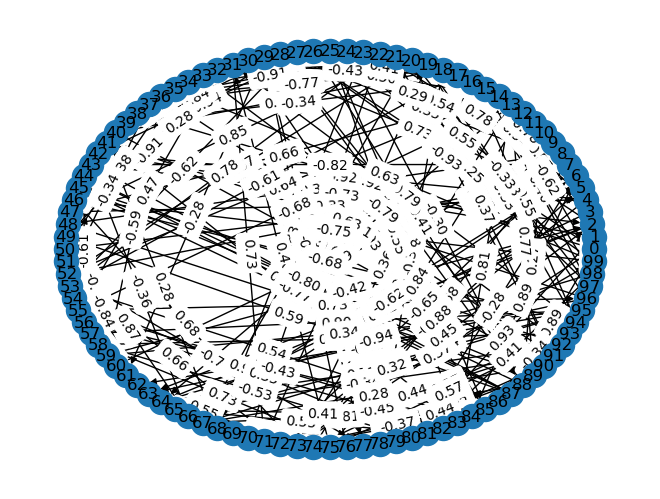

In [7]:
n_nodes = 100
exp_dens = 2

DATA_PATH = Path("/data/m015k/data/bicycle/data")
# weights = np.load(DATA_PATH / "../synth_benchmark_data/obs_inter_data/weights.npy")

# graph = nx.from_numpy_array(weights, create_using=nx.DiGraph)

gen_model = linearSEM(graph, contractive=True)
gen_model.weights = weights

pos = nx.circular_layout(graph)
edge_labels = {edge: "{:.2f}".format(gen_model.weights[edge[0],edge[1]]) for edge in graph.edges}

nx.draw(graph, with_labels=True, pos=pos)
_ = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

In [8]:
data_gen = Dataset(n_nodes=n_nodes, 
                   expected_density=exp_dens,
                   n_samples=5000,
                   n_experiments=n_nodes,
                   graph_provided=True,
                   graph=graph,
                   gen_model_provided=True,
                   gen_model=gen_model,
                   contractive=True)

purely_obs_datasets = list()
for i in range(10):
    purely_obs_datasets.append(data_gen.generate(interventions=False))
    
intervention_datasets = list()
for i in range(10):
    intervention_datasets.append(data_gen.generate())


In [10]:
data_0 = (
    [datasets[0] for datasets in purely_obs_datasets],
    [[None]] * 10
)
datas = [data_0]

# Training_data

data_0 = (
    [datasets[0] for datasets in purely_obs_datasets],
    [[None]] * 10
)

data_1 = (
    [purely_obs_datasets[i][0] for i in range(5)] + [intervention_datasets[i][7] for i in range(5)],
    [[None]]*5 + [[7]]*5
)

data_2 = (
    [purely_obs_datasets[i][0] for i in range(4)] + [intervention_datasets[i][4] for i in range(3)] + [intervention_datasets[i][7] for i in range(3)],
    [[None]]*4 + [[4]]*3 + [[7]]*3
) 

data_3 = (
    [purely_obs_datasets[i][0] for i in range(2)] + [intervention_datasets[i][0] for i in range(3)] + [intervention_datasets[i][4] for i in range(2)] + [intervention_datasets[i][7] for i in range(3)],
    [[None]]*2 + [[0]]*3 + [[4]]*2 + [[7]]*3
) 

data_4 = (
    [purely_obs_datasets[i][0] for i in range(2)] + [intervention_datasets[i][0] for i in range(2)] + [intervention_datasets[i][1] for i in range(2)] + [intervention_datasets[i][4] for i in range(2)] + [intervention_datasets[i][7] for i in range(2)],
    [[None]]*2 + [[0]]*2 + [[1]]*2 + [[4]]*2 + [[7]]*2
) 

data_5 = (
    [purely_obs_datasets[i][0] for i in range(2)] + [intervention_datasets[i][0] for i in range(1)] + [intervention_datasets[i][1] for i in range(2)] + [intervention_datasets[i][2] for i in range(1)] + [intervention_datasets[i][4] for i in range(2)] + [intervention_datasets[i][7] for i in range(2)],
    [[None]]*2 + [[0]]*1 + [[1]]*2 + [[2]]*1 + [[4]]*2 + [[7]]*2
) 

data_6 = (
    [purely_obs_datasets[i][0] for i in range(1)] + [intervention_datasets[i][0] for i in range(2)] + [intervention_datasets[i][1] for i in range(1)] + [intervention_datasets[i][2] for i in range(2)] + [intervention_datasets[i][3] for i in range(1)] + [intervention_datasets[i][4] for i in range(2)] + [intervention_datasets[i][7] for i in range(1)],
    [[None]] + [[0]]*2 + [[1]] + [[2]]*2 + [[3]] + [[4]]*2 + [[7]]
) 

data_7 = (
    [purely_obs_datasets[i][0] for i in range(1)] + [intervention_datasets[i][0] for i in range(2)] + [intervention_datasets[i][1] for i in range(1)] + [intervention_datasets[i][2] for i in range(2)] + [intervention_datasets[i][3] for i in range(1)] + [intervention_datasets[i][4] for i in range(1)] + [intervention_datasets[i][5] for i in range(1)] + [intervention_datasets[i][7] for i in range(1)],
    [[None]*1] + [[0]]*2 + [[1]]*1 + [[2]]*2 + [[3]*1] + [[4]*1] + [[5]*1] + [[7]*1]
) 

data_8 = (
    [purely_obs_datasets[i][0] for i in range(1)] + [intervention_datasets[i][0] for i in range(2)] + [intervention_datasets[i][1] for i in range(1)] + [intervention_datasets[i][2] for i in range(1)] + [intervention_datasets[i][3] for i in range(1)] + [intervention_datasets[i][4] for i in range(1)] + [intervention_datasets[i][5] for i in range(1)] + [intervention_datasets[i][6] for i in range(1)] + [intervention_datasets[i][7] for i in range(1)],
    [[None]*1] + [[0]*1] + [[1]]*2 + [[2]*1] + [[3]*1] + [[4]*1] + [[5]*1] + [[6]*1] + [[7]*1]
) 

data_9 = (
    [purely_obs_datasets[i][0] for i in range(1)] + [intervention_datasets[i][0] for i in range(1)] + [intervention_datasets[i][1] for i in range(1)] + [intervention_datasets[i][2] for i in range(1)] + [intervention_datasets[i][3] for i in range(1)] + [intervention_datasets[i][4] for i in range(1)] + [intervention_datasets[i][5] for i in range(1)] + [intervention_datasets[i][6] for i in range(1)] + [intervention_datasets[i][7] for i in range(1)] + [intervention_datasets[i][8] for i in range(1)],
    [[None]*1] + [[0]*1] + [[1]*1] + [[2]*1] + [[3]*1] + [[4]*1] + [[5]*1] + [[6]*1] + [[7]*1] + [[8]*1]
)
                  


datas = [data_0, data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9]

val_data_gen = Dataset(n_nodes=n_nodes, 
                   expected_density=exp_dens,
                   n_samples=5000,
                   n_experiments=n_nodes,
                   graph_provided=True,
                   graph=graph,
                   gen_model_provided=True,
                   gen_model=gen_model,
                   contractive=True,
                   min_targets=2,
                   max_targets=3,
                   mode='no-constraint')

val_datasets = val_data_gen.generate(fixed_interventions=True)
val_intervention_sets = val_data_gen.targets

## Baseline (LLC) Initialization and Training

auprc_list = list()
nll_list = list()
cm_list = list()

llc_wrapper = LLCClassWrapper()

for i in range(1,10):
    data = datas[i]
    print("Iteration: {}".format(i+1))
    llc_wrapper = LLCClassWrapper()
    
    llc_datasets = intervention_datasets[0][:i]
    llc_interventions = data_gen.targets[:i]
    
    llc_wrapper.train(llc_datasets, llc_interventions)
    
    _, area = llc_wrapper.get_auprc(np.abs(weights) > 0)
    auprc_list.append(area)
    
    nll = llc_wrapper.predictLikelihood(val_datasets, val_intervention_sets)
    nll_list.append(np.mean(nll))
    
    cm = llc_wrapper.predictConditionalMean(val_datasets, val_intervention_sets)
    cm_list.append(
        np.mean([((dataset.mean(axis=0) - cond_mean)**2).mean() for dataset, cond_mean in zip(val_datasets, cm)])
    )
    
    print("AURPC: {}, NLL: {}, CM: {}".format(area, nll_list[-1], cm_list[-1]))
    

llc_auprc = auprc_list
llc_nll = nll_list
llc_cm = cm_list

## Model initialization and Training

In [11]:
auprc_list = list()
nll_list = list()
cm_list = list()

print("Iteration: {}".format(i+1))
data = datas[0]
nodags_wrapper = resflow_train_test_wrapper(
        n_nodes=n_nodes,
        batch_size=64,
        l1_reg=True,
        lambda_c=1e-2,
        n_lip_iter=5,
        fun_type='gst-mlp',
        act_fun='none',
        epochs=100,
        lr=1e-2,
        lip_const=0.99,
        optim='adam',
        inline=True,
        n_hidden=0,
        lin_logdet=False,
        dag_input=False,
        thresh_val=0.05,
        upd_lip=True)

nodags_wrapper.train(data[0], data[1], batch_size=1024)
print()

#     _, area = nodags_wrapper.get_auprc(np.abs(gen_model.weights) > 0)
#     auprc_list.append(area)
    
#     nll = nodags_wrapper.predictLikelihood(val_datasets, val_intervention_sets)
#     nll_list.append(np.mean(nll))
    
#     cm = nodags_wrapper.predictConditionalMean(val_datasets, val_intervention_sets)
#     cm_list.append(np.mean([((dataset.mean(axis=0) - cond_mean)**2).mean() for dataset, cond_mean in zip(val_datasets, cm)]))
    
#     print("AUPRC: {}, NLL: {}, CM:{}".format(area, nll_list[-1], cm_list[-1]))

Iteration: 10
Initializing the model
Number of Parameters : 20102
Starting Training


KeyboardInterrupt: 

In [15]:
gst_auprc = auprc_list
gst_nll = nll_list
gst_cm = cm_list

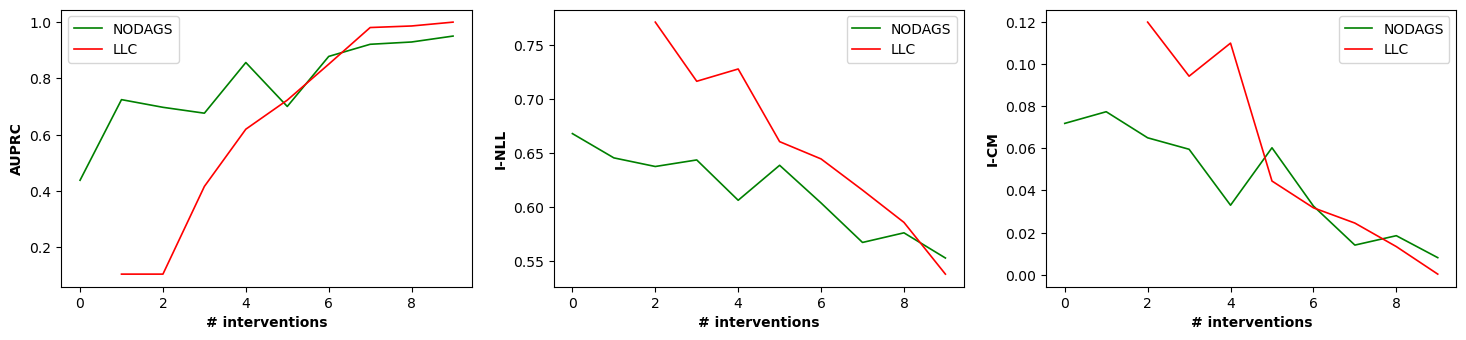

In [16]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3.6)
fig.set_figwidth(18)

axs[0].plot(range(10), gst_auprc, color='green', linewidth=1.2, label='NODAGS')
axs[0].plot(range(1, 10), llc_auprc, color='red', linewidth=1.2, label='LLC')
axs[0].legend()
axs[0].set_xlabel('# interventions', fontweight='bold')
axs[0].set_ylabel('AUPRC', fontweight='bold')

axs[1].plot(range(10), gst_nll, color='green', linewidth=1.2, label='NODAGS')
axs[1].plot(range(1, 10), llc_nll, color='red', linewidth=1.2, label='LLC')
axs[1].legend()
axs[1].set_xlabel('# interventions', fontweight='bold')
axs[1].set_ylabel('I-NLL', fontweight='bold')

axs[2].plot(range(10), gst_cm, color='green', linewidth=1.2, label='NODAGS')
axs[2].plot(range(1, 10), llc_cm, color='red', linewidth=1.2, label='LLC')
axs[2].legend()
axs[2].set_xlabel('# interventions', fontweight='bold')
axs[2].set_ylabel('I-CM', fontweight='bold')

plt.show()